# **Emotion Detection Neural Network with Activation Mapping**

In this notebook, a convolutional neural network is trained on the FER2013 dataset. The network is also designed to use Global Average Pooling layer to create a feature map to show which portion of the image is influencial on a given predition.

Global Average Pool: https://arxiv.org/abs/1512.04150

Code Based on: https://github.com/Divyanshupy/CLASS-ACTIVATION-MAPS/blob/master/Class%20Activation%20Maps%20without%20MaxPooling.ipynb

The entire folder should be able to uploaded to Google Colab and work if ```path``` is set to be the path to the folder.

In [71]:
path = r'/content/gdrive/My Drive/UCI-Classes/DL_class/Project/upload'

In [72]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [73]:
from numpy import mean
from numpy import std
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling2D
from keras.layers import SpatialDropout2D
from keras.layers import GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

from keras.layers import BatchNormalization
from keras.optimizers import SGD
import keras as keras
# %%
from fer2013_loader import fer2013
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import time
from keras.layers import AveragePooling2D

In [74]:
# def prep_pixels(train, test):
# 	# convert from integers to floats
# 	train_norm = train.astype('float32')
# 	test_norm = test.astype('float32')
# 	# normalize to range 0-1
# 	train_norm = train_norm / 255.0
# 	test_norm = test_norm / 255.0
# 	# return normalized images
# 	return train_norm, test_norm

Loading FER2013 data(loader script should also be in this git), shuffles, and splits data into train, validation, and test sets.

In [75]:
data = fer2013()
data.shuffle(seed=10)
trainX,trainY, testX,testY = data.split_data(seed=11,test_size=0.2)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=11)


Preprocessing of the data. Normalizing to 255 and removes any samples that is empty(ie only zeros).

In [76]:
indices = (np.sum(trainX,axis=(1,2))>0)[:,0]
trainX = trainX[indices]/255.0
trainY = trainY[indices]


indices = (np.sum(valX,axis=(1,2))>0)[:,0]
valX = valX[indices]/255.0
valY = valY[indices]


indices = (np.sum(testX,axis=(1,2))>0)[:,0]
testX = testX[indices]/255.0
testY = testY[indices]

Print out sizes to confirm everything looks good.

In [77]:
data_len = len(trainX)

print('Train X Shape: ',trainX.shape)
print('Train Y Shape: ',trainY.shape)



Train X Shape:  (22961, 48, 48, 1)
Train Y Shape:  (22961, 7)


Creating a augmentation function. Augments the initial dataset with images with rotations, translations, zooms, flips, ect. 

Due to memory sizes may be limited in amount of augmentation until better implmenetation occurs. Had issues previously using the flow function with images directly(couldn't find all of them on the drive).

Also creates a shuffle function for randomizing the data.


In [78]:
def augment_data(trainData, valData, testData,augment=True,num_multiple=2,rotation_range=0,width_shift_range=0,
                 height_shift_range=0,zoom_range=0.2,horizontal_flip=True,seed=10):
    augX = np.zeros((num_multiple*len(trainX),len(trainX[0]),len(trainX[0][0]),len(trainX[0][0][0])))
    augY = np.zeros((num_multiple*len(trainY),len(trainY[0])))

    augValX = np.zeros((num_multiple*len(valX),len(valX[0]),len(valX[0][0]),len(valX[0][0][0])))
    augValY = np.zeros((num_multiple*len(valY),len(valY[0])))


    augTestX = np.zeros((num_multiple*len(testX),len(testX[0]),len(testX[0][0]),len(testX[0][0][0])))
    augTestY = np.zeros((num_multiple*len(testY),len(testY[0])))

    if augment == True:
        datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip)

        history = []
        datagen.fit(trainX)

        seedArray = np.linspace(0,num_multiple-1,num_multiple).astype(int) + seed

        for idx, seed_val in enumerate(seedArray):
            for x_batch, y_batch in datagen.flow(trainX, trainY, batch_size=len(trainX),seed=seed_val):
                augX[idx*(len(trainX)):(idx+1)*(len(trainX))] = x_batch
                augY[idx*(len(trainX)):(idx+1)*(len(trainX))] = y_batch
                #print((idx)*(len(trainX)),(idx+1)*(len(trainX)))
                break

        for idx, seed_val in enumerate(seedArray):
            for x_batch, y_batch in datagen.flow(valX, valY, batch_size=len(valX),seed=seed_val):
                augValX[idx*(len(valX)):(idx+1)*(len(valX))] = x_batch
                augValY[idx*(len(valX)):(idx+1)*(len(valX))] = y_batch
             #   print((idx)*(len(valX)),(idx+1)*(len(valX)))
                break
                
        for idx, seed_val in enumerate(seedArray):
            for x_batch, y_batch in datagen.flow(testX, testY, batch_size=len(testX),seed=seed_val):
                augTestX[idx*(len(testX)):(idx+1)*(len(testX))] = x_batch
                augTestY[idx*(len(testX)):(idx+1)*(len(testX))] = y_batch
                #print((idx)*(len(testX)),(idx+1)*(len(testX)))
                break
    else:
        print('Skipping data augmentation')
        augX = trainX
        augY = trainY
        augValX = valX
        augValY = valY
        augTestX = testX
        augTestY = testY



    return augX, augY, augValX, augValY, augTestX, augTestY

def shuffle_data(X,Y,seed=10):

    index = np.linspace(0,len(X)-1,len(X)).astype(int)

    gen = np.random.default_rng(seed=seed)
    gen.shuffle(index)
    X = X[index]
    Y = Y[index]

    return X, Y



Augmenting the data

(Currently due to memory issues/crashing issues augmentation is not occuring.)

In [79]:
augX, augY, augValX, augValY, augTestX, augTestY= augment_data(trainData= (trainX, trainY), valData  = (valX, valY), testData = (testX,testY),
                                                               augment=False,num_multiple=2,rotation_range=20,width_shift_range=0.1,
                                                               height_shift_range=0.1,zoom_range=0.2,horizontal_flip=True)

augX, augY = shuffle_data(augX,augY)
augValX, augValY = shuffle_data(augValX,augValY)
augTestX, augTestY = shuffle_data(augTestX,augTestY)

Skipping data augmentation


Displaying various images from the dataset.

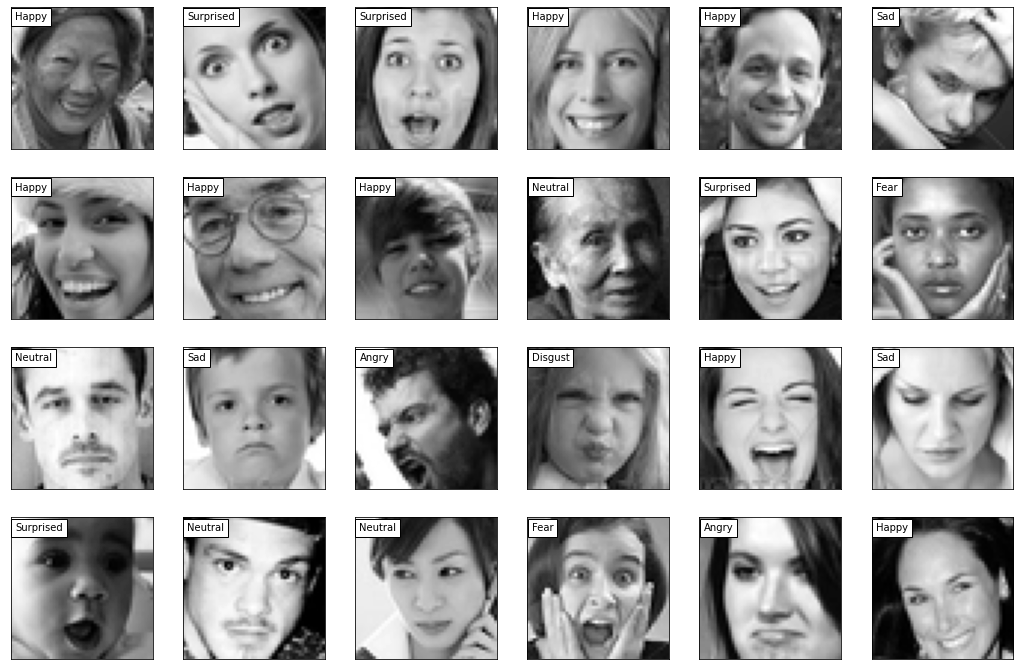

In [80]:
ncols = 6
nrows = 4

fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(3*ncols,3*nrows))

idx = 0
for ii in range(nrows):
    for jj in range(ncols):
        ax[ii,jj].imshow(augX[idx,:,:,0],cmap='gray')
        ax[ii,jj].set_xticks([])
        ax[ii,jj].set_yticks([])
        ax[ii,jj].text(1,4,data.label_key(np.argmax(augY[idx])),bbox=dict(facecolor='w'))
        idx += 1

Check to make sure there are no empty arrays

In [81]:
for ii in range(len(augX)):

    if np.sum(augX[ii]) == 0.0:
        print('here',ii)
        plt.figure()
        plt.imshow(augX[ii][:,:,0])

Building model.

Note the fact that after the last spatial dropout a GlobalAveragePooling layer is used and feeds directly into the final dense layer.

By doing this we can look at the relative weights of the final images created by the neural network and use it to craete the feature activation maps.

In [82]:
def define_model(input_shape=(28,28,1),output_shape=7,padding='same',dropoutRate = 0.0,num_filters=128):
    model = Sequential()
    model.add(Conv2D(num_filters, (3, 3), activation='relu',padding=padding,input_shape=input_shape))
    model.add(Conv2D(num_filters, (3, 3), activation='relu',padding=padding))
    model.add(Conv2D(num_filters, (3, 3), activation='relu',padding=padding))
    model.add(Conv2D(num_filters, (3, 3), activation='relu',padding=padding))

    model.add(SpatialDropout2D(dropoutRate))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(num_filters, (3, 3), activation='relu',padding=padding))
    model.add(Conv2D(num_filters, (3, 3), activation='relu',padding=padding))
    model.add(Conv2D(num_filters, (3, 3), activation='relu',padding=padding))
    model.add(Conv2D(num_filters, (3, 3), activation='relu',padding=padding))

    model.add(SpatialDropout2D(dropoutRate))
    model.add(MaxPooling2D(pool_size=(2, 2)))    


 

    model.add(GlobalAveragePooling2D())
    model.add(Dense(output_shape,activation='softmax'))


    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    return model

In [83]:
model = define_model(input_shape=augX[0].shape,output_shape=augY.shape[1],padding='same',dropoutRate = 0.1,num_filters=128)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 48, 48, 128)       1280      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
spatial_dropout2d_12 (Spatia (None, 48, 48, 128)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 24, 24, 128)      

Training model with early stopping and timing duration.

In [ ]:
startTime = time.time()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(augX, augY,epochs=40,batch_size=64, validation_data=(augValX,augValY), verbose=1,shuffle=True,callbacks=[es])

trainTime = time.time() - startTime

Epoch 1/40
359/359 [==============================] - 33s 89ms/step - loss: 1.8380 - accuracy: 0.2470 - val_loss: 1.8031 - val_accuracy: 0.2622
Epoch 2/40
359/359 [==============================] - 32s 88ms/step - loss: 1.7970 - accuracy: 0.2523 - val_loss: 1.7855 - val_accuracy: 0.2686
Epoch 3/40
359/359 [==============================] - 31s 87ms/step - loss: 1.7871 - accuracy: 0.2498 - val_loss: 1.7562 - val_accuracy: 0.2807
Epoch 4/40
359/359 [==============================] - 31s 88ms/step - loss: 1.7622 - accuracy: 0.2682 - val_loss: 1.6876 - val_accuracy: 0.3233
Epoch 5/40
359/359 [==============================] - 32s 88ms/step - loss: 1.6714 - accuracy: 0.3122 - val_loss: 1.5640 - val_accuracy: 0.3791
Epoch 6/40
359/359 [==============================] - 32s 88ms/step - loss: 1.5303 - accuracy: 0.3927 - val_loss: 1.4708 - val_accuracy: 0.4369
Epoch 7/40
359/359 [==============================] - 32s 88ms/step - loss: 1.4032 - accuracy: 0.4618 - val_loss: 1.2846 - val_accuracy:

Evaluating model and saving

In [ ]:
model.summary()
eva = model.evaluate(augTestX,augTestY)

model_name = 'model_loss_%f_acc_%f_time_%f'%(eva[0],eva[1],startTime)

model.save(model_name+'.h5')



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 48, 48, 128)       1280      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
spatial_dropout2d_12 (Spatia (None, 48, 48, 128)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
print(eva)

[1.0217278003692627, 0.8050717711448669]


Plotting loss and accuracy metrics

['loss', 'accuracy']


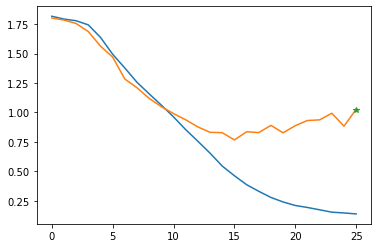

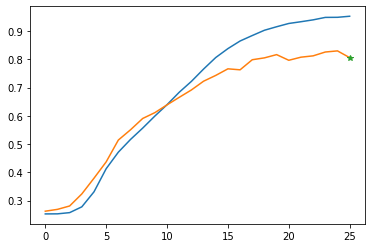

In [ ]:
print(model.metrics_names)

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.plot(len(history.history['val_loss'])-1,eva[0],'*')
plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(len(history.history['val_accuracy'])-1,eva[1],'*')

Converting network structure into one that outputs both the results along with the class activation map values.

In [ ]:
from keras.models import Model
import scipy as sp
gap_weights = model.layers[-1].get_weights()[0]
print(gap_weights.shape)
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()
cam_model.save(model_name+'_att.h5')

(128, 7)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40_input (InputLayer) [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 48, 48, 128)       1280      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
spatial_dropout2d_12 (Spatia (None, 48, 48, 128)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 128)  

Dispalying the output of the CAM model on a sampling of images from the test dataset.

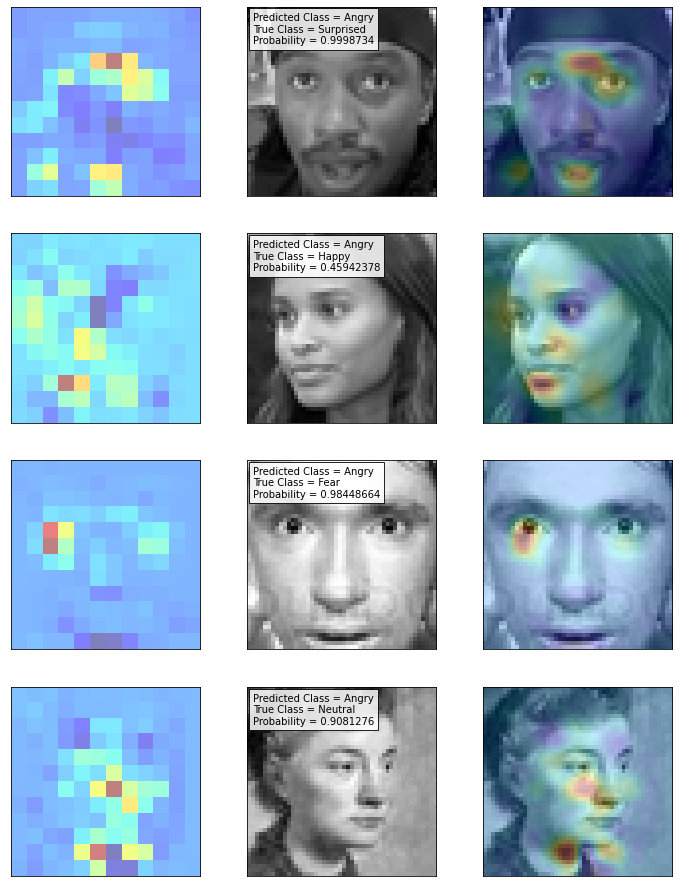

In [ ]:
import cv2


features,output = cam_model.predict(augTestX,batch_size=16)


nrows = 4
fig, ax = plt.subplots(ncols=3,nrows=nrows,figsize=(4*3,4*nrows))

for idx in range(nrows):
    features_for_one_img = features[idx,:,:,:]
    #height_roomout = X_train.shape[1]/features_for_one_img.shape[0]
    #width_roomout  = X_train.shape[2]/features_for_one_img.shape[1]
    #print(height_roomout,width_roomout)
 
    #cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)
    #print(cam_features.shape)
    pred = np.argmax(output[idx])
    cam_features = features_for_one_img
    
    
    cam_weights = gap_weights[:,pred]
    cam_output  = np.dot(cam_features,cam_weights)
    #print(features_for_one_img.shape)

    buf = 'Predicted Class = ' +data.label_key( np.argmax(pred) )+ '\nTrue Class = ' + data.label_key(np.argmax( augTestY[idx])) + '\nProbability = ' + str(output[idx][pred])

    ax[idx,1].text(1,1,buf,va='top',ha='left',bbox=dict(facecolor='w', alpha=0.85))

 #   ax[0].imshow(np.squeeze(testY[idx],-1), alpha=0.5)

    ax[idx,0].imshow(cam_output, cmap='jet', alpha=0.5)

    ax[idx,1].imshow(augTestX[idx,:,:,0],cmap='gray')
     

    ax[idx,2].imshow(augTestX[idx,:,:,0],cmap='gray')

    ax[idx,2].imshow(cv2.resize(cam_output, dsize=augTestX[idx,:,:,0].shape, interpolation=cv2.INTER_CUBIC), cmap='jet', alpha=0.25)

    for axis in ax[idx]:
        axis.set_xticks([])
        axis.set_yticks([])

plt.show()

Statistics for the Model

In [ ]:
# %%
print('FER2013 Class Breakdown')
binnedY = np.sum(augTestY,axis=0)
binnedPred = np.sum(output,axis=0)
setSize = len(augTestY)
for ii in range(len(augTestY[0])):
    print(data.label_key(ii) + ' %0.2f '%(binnedY[ii]/setSize))
print('Errors')
for ii in range(len(augTestY[0])):
    print(data.label_key(ii) + ' %0.3f '%(np.abs((binnedY[ii]-binnedPred[ii]))/binnedY[ii]))

print('Accuracy')
for ii in range(len(augTestY[0])):
    print(data.label_key(ii) + ' %0.3f '%(1-np.abs((binnedY[ii]-binnedPred[ii]))/binnedY[ii]))
# %%


FER2013 Class Breakdown
Angry 0.14 
Disgust 0.01 
Fear 0.15 
Happy 0.24 
Sad 0.17 
Surprised 0.11 
Neutral 0.18 
Errors
Angry 0.148 
Disgust 0.296 
Fear 0.354 
Happy 0.037 
Sad 0.232 
Surprised 0.081 
Neutral 0.165 
Accuracy
Angry 0.852 
Disgust 0.704 
Fear 0.646 
Happy 0.963 
Sad 0.768 
Surprised 0.919 
Neutral 0.835 


Some more images with the given Class activation map plotted over it with the correctly predicted classes being red and incorrectly labeled being blue.

In [ ]:
squareSize = 5
counter = 0
features.shape
for kk in range(5):

    fig, ax = plt.subplots(ncols=squareSize,nrows=squareSize,figsize = (15,10))




    for ii in range(squareSize):
        for jj in range(squareSize):
            features_for_one_img = features[counter,:,:,:]
            cam_features = features_for_one_img
            pred = np.argmax(output[counter])

            
            cam_weights = gap_weights[:,pred]
            cam_output  = np.dot(cam_features,cam_weights)
            if np.argmax(augTestY[counter])==pred:
                color='blue'
            else:
                color='darkred'

            ax[ii,jj].imshow(augTestX[counter][:,:,0],cmap='gray')
            ax[ii,jj].imshow((cv2.resize(cam_output, dsize=augTestX[idx,:,:,0].shape, interpolation=cv2.INTER_CUBIC)), cmap='jet', alpha=0.35)

            ax[ii,jj].set_title('T: %s\nP: %s  P. Val: %0.2f'%(data.label_key(np.argmax(augTestY[counter])),data.label_key(pred),np.max(output[counter])),color=color)
            ax[ii,jj].axis('off')
            counter +=1

    plt.tight_layout()
    plt.savefig('%05d.png'%kk)
    #plt.close()



In [ ]:
err = np.sum(np.abs(np.argmax(augTestY,axis=1)-np.argmax(output,axis=1))==0)/len(output)
print(err)

0.8050717570015327


In [ ]:
matrix = np.zeros((7,7))
for ii in range(len(output)):
    matrix[np.argmax(output[ii]),np.argmax(augTestY[ii])] += 1

for ii in range(len(matrix)):
    matrix[ii] = (matrix[ii]/np.sum(matrix[ii]))
#matrix[0,3] += 1000

The confusion matrix for the network. Normalized to the 'True' percentages.

Text(51.0, 0.5, 'Predicted')

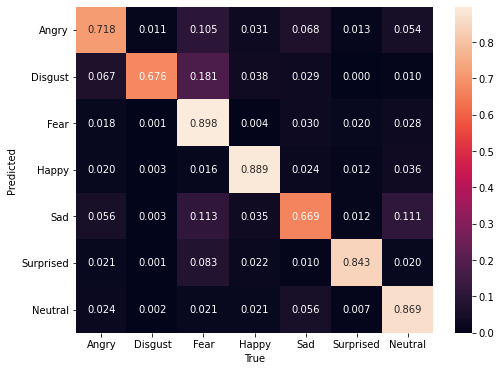

In [ ]:
import seaborn as sns
plt.figure(figsize = (8,6))
#plt.imshow(matrix/np.sum(matrix,axis=1))

labels = []
for ii in range(7):
    labels.append(data.label_key(ii))

sns.heatmap(matrix,annot=True,fmt='0.3f',xticklabels=labels,yticklabels=labels)

plt.xlabel('True')
plt.ylabel('Predicted')


In [ ]:
for ii in range(7):
    print('%0.2f %0.2f %0.2f %0.2f %0.2f %0.2f %0.2f'%((matrix[ii,0]/np.sum(matrix[ii])),matrix[ii,1]/np.sum(matrix[ii]),matrix[ii,2]/np.sum(matrix[ii]),matrix[ii,3]/np.sum(matrix[ii]),matrix[ii,4]/np.sum(matrix[ii]),matrix[ii,5]/np.sum(matrix[ii]),matrix[ii,6]/np.sum(matrix[ii])))


0.72 0.01 0.11 0.03 0.07 0.01 0.05
0.07 0.68 0.18 0.04 0.03 0.00 0.01
0.02 0.00 0.90 0.00 0.03 0.02 0.03
0.02 0.00 0.02 0.89 0.02 0.01 0.04
0.06 0.00 0.11 0.04 0.67 0.01 0.11
0.02 0.00 0.08 0.02 0.01 0.84 0.02
0.02 0.00 0.02 0.02 0.06 0.01 0.87
